In [3]:
device_name = 'cuda:0'
model_name = 'V1'

# uncomment this block to grab user input
# import sys
# args = sys.argv
# device_name = args[1]
#model_name = args[2]

from tim import *
#os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# comment out unavailable devices - or edit workload (1 is lab laptop and lowest)
# a value of 8 would apply 8 jobs to every 1 given to laptop
# assigns jobs in order of dict
instances = {
         'mlserver2021 cuda:0':8,
         'mlserver2021 cuda:1':8,
#         'apollo cuda:0':1,
         'torch cuda:0':4,
         'pyro cuda:0':4,
         'phoenix cuda:0':4,
#         'mlserver2019 cuda:0':6,
#         'mlserver2019 cuda:1':6,
         'mlserver2019 cuda:2':6,
}
local_params = read_local_params()
instance_name = local_params['server_name'] + ' ' + device_name
print('instance_name', instance_name)
print('#GPUs', torch.cuda.device_count())
print('torch available?', torch.cuda.is_available())
print('mp.cpu_count', mp.cpu_count())
print('os.cpu_count', os.cpu_count())
print('version 12/13 11:45')

instance_name apollo cuda:0
#GPUs 1
torch available? True
mp.cpu_count 8
os.cpu_count 8
version 12/13 11:45


In [5]:
# DATA

# get data paths for train/val/test
#data_dir = 'data/depth_airsimnh_RGB_576_1024_depth_map_144_156/'
data_dir = 'data/airsimnh/'
X_dir = data_dir + 'image/'
Y_dir = data_dir + 'depth/'

train_list = [s.replace('\n', '') for s in list(open(data_dir + 'train.txt'))]
val_list = train_list[:500]
train_list = train_list[500:]
test_list = [s.replace('\n', '') for s in list(open(data_dir + 'test.txt'))]

X_train_list = [X_dir + img_name for img_name in train_list]
Y_train_list = [Y_dir + img_name for img_name in train_list]
X_val_list = [X_dir + img_name for img_name in val_list]
Y_val_list = [Y_dir + img_name for img_name in val_list]
X_test_list = [X_dir + img_name for img_name in test_list]
Y_test_list = [Y_dir + img_name for img_name in test_list]

# read in imgs 
#X_shape = [3,576,1024]
# X_shape = [3,144,256]
# Y_shape = [1,144,256]
# X_train = get_imgs2(X_train_list,1,[len(X_train_list)] + X_shape)
# Y_train = get_imgs2(Y_train_list,0,[len(Y_train_list)] + Y_shape)
# X_val = get_imgs2(X_val_list,1,[len(X_val_list)] + X_shape)
# Y_val = get_imgs2(Y_val_list,0,[len(Y_val_list)] + Y_shape)
# X_test = get_imgs2(X_test_list,1,[len(X_test_list)] + X_shape)
# Y_test = get_imgs2(Y_test_list,0,[len(Y_test_list)] + Y_shape)
n = 6
b = 100
pool = Pool(processes=n)
X_train = np.stack(concat_list(pool.starmap(get_imgs, 
                       [(X_train_list[i*b:min(len(X_train_list), (i+1)*b)],1) for i in range(int(len(X_train_list)/b))])))
Y_train = np.stack(concat_list(pool.starmap(get_imgs, 
                       [(Y_train_list[i*b:min(len(Y_train_list), (i+1)*b)],0) for i in range(int(len(Y_train_list)/b))])))
X_val = np.stack(concat_list(pool.starmap(get_imgs, 
                       [(X_val_list[i*b:min(len(X_val_list), (i+1)*b)],1) for i in range(int(len(X_val_list)/b))])))
Y_val = np.stack(concat_list(pool.starmap(get_imgs, 
                       [(Y_val_list[i*b:min(len(Y_val_list), (i+1)*b)],0) for i in range(int(len(Y_val_list)/b))])))
X_test = np.stack(concat_list(pool.starmap(get_imgs,
                       [(X_test_list[i*b:min(len(X_test_list), (i+1)*b)],1) for i in range(int(len(X_test_list)/b))])))
Y_test = np.stack(concat_list(pool.starmap(get_imgs, 
                       [(Y_test_list[i*b:min(len(Y_test_list), (i+1)*b)],0) for i in range(int(len(Y_test_list)/b))])))

# calc stats
train_mean, train_std = get_mean_std(X_train)

# assumed states
assumed_mean = np.zeros((3, 1, 1), dtype=np.float32)
assumed_std = np.zeros((3, 1, 1), dtype=np.float32) 
assumed_mean[0, 0, 0] = 0.485
assumed_mean[1, 0, 0] = 0.456
assumed_mean[2, 0, 0] = 0.406
assumed_std[0, 0, 0] = 0.229
assumed_std[1, 0, 0] = 0.224
assumed_std[2, 0, 0] = 0.225

print('X_train.shape', X_train.shape)
print('Y_train.shape', Y_train.shape)
print('X_val.shape', X_val.shape)
print('Y_val.shape', Y_val.shape)
print('X_test.shape', X_test.shape)
print('Y_test.shape', Y_test.shape)

X_train.shape (4000, 3, 144, 256)
Y_train.shape (4000, 1, 144, 256)
X_val.shape (500, 3, 144, 256)
Y_val.shape (500, 1, 144, 256)
X_test.shape (500, 3, 144, 256)
Y_test.shape (500, 1, 144, 256)


In [3]:
X_train2 = X_train.swapaxes(2, 3)
Y_train2 = Y_train.swapaxes(2, 3)
X_val2 = X_val.swapaxes(2, 3)
Y_val2 = Y_val.swapaxes(2, 3)
X_test2 = X_test.swapaxes(2, 3)
Y_test2 = Y_test.swapaxes(2, 3)

print('X_train2.shape', X_train2.shape)
print('Y_train2.shape', Y_train2.shape)
print('X_val2.shape', X_val2.shape)
print('Y_val2.shape', Y_val2.shape)
print('X_test2.shape', X_test2.shape)
print('Y_test2.shape', Y_test2.shape)

X_train2.shape (4000, 3, 256, 144)
Y_train2.shape (4000, 1, 256, 144)
X_val2.shape (500, 3, 256, 144)
Y_val2.shape (500, 1, 256, 144)
X_test2.shape (500, 3, 256, 144)
Y_test2.shape (500, 1, 256, 144)


In [ ]:
from PIL import Image, ImageOps
from torchvision import transforms

def make_dataset(root, is_train):
    if is_train:
        print('train')

        input = open(os.path.join(root, 'data/airsimnh/train.txt'))
        depth_t = open(os.path.join(root, 'data/airsimnh/train.txt'))
        image = [(os.path.join(root, 'data/airsimnh/image/', img_name.strip('\n'))) for img_name in input]
        depth = [(os.path.join(root, 'data/airsimnh/depth/', img_name.strip('\n'))) for img_name in depth_t]

        input.close()

        return [[image[i], depth[i]] for i in range(len(image))] 

    else:
        print('test')

        input = open(os.path.join(root, 'data/airsimnh/test.txt'))
        depth_t = open(os.path.join(root, 'data/airsimnh/test.txt'))

        image = [(os.path.join(root, 'data/airsimnh/image/', img_name.strip('\n'))) for img_name in input]
        depth = [(os.path.join(root, 'data/airsimnh/depth/', img_name.strip('\n'))) for img_name in depth_t]

        input.close()

        return [[image[i], depth[i]]  for i in range(len(image))] #[[image[i], gt[i], depth[i]]for i in range(len(image))]

class ImageFolder(Dataset):
    def __init__(self, root, triple_transform=None, transform=None, target_transform=None, is_train=True):
        self.root = root
        self.imgs = make_dataset(root, is_train)
        self.triple_transform = triple_transform
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        img_path, depth_path = self.imgs[index]
        #print(img_path)
        #print(gt_path)
        #print(depth_path)
        img = Image.open(img_path)
        # target = Image.open(gt_path)
        depth = Image.open(depth_path)
        depth = ImageOps.grayscale(depth)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            #target = self.target_transform(target)
            depth = self.target_transform(depth)

        return img.cuda(), depth.cuda() #img, target, depth

    def __len__(self):
        return len(self.imgs)
    
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 144))
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

to_pil = transforms.ToPILImage()

test_set = ImageFolder(os.getcwd(), transform=transform, target_transform=transform, is_train=False)
test_loader = DataLoader(test_set, batch_size=20)

result_avg = 0
loss = 0
teacher_criterion = nn.L1Loss()
for i, data_batch in enumerate(test_loader):
    if (i+1) % int(len(test_loader)/2) == 0:
        print('At batch:', i+1, '\t----\tPreformace:', result_avg/(i+1))
    
    input, target = data_batch
    output = teacher(input.to(device_name))
    
    loss = teacher_criterion(output, target.to(device_name))
    result_avg += loss.item()
result_avg /= len(test_loader)
print("FINAL EVAL: ", result_avg)

In [9]:
import nets
from torchvision import transforms

class MyDataset2(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __getitem__(self, index):
        tran = transforms.Resize((256, 144))
        return tran(torch.from_numpy((self.X[index]-assumed_mean)/assumed_std)), tran(torch.from_numpy(self.Y[index]))
    def __len__(self):
        return len(self.Y)
test_loader = DataLoader(MyDataset2(X_test/255, Y_test/255), batch_size=20, shuffle=False)
device_name = 'cuda:0'

# ian_teacher_path = 'Ians_Models/Teacher.pth'
# teacher = nets.DGNLNet_v1()
# teacher_state_dict = torch.load(ian_teacher_path)
# teacher.load_state_dict(teacher_state_dict)
# teacher = teacher.to(device_name)

teacher = torch.load('models/IanV1_teacher.pt').to(device_name)

result_avg = 0
loss = 0
teacher_criterion = nn.L1Loss()
for i, data_batch in enumerate(test_loader):
    if (i+1) % int(len(test_loader)/2) == 0:
        print('At batch:', i+1, '\t----\tPreformace:', result_avg/(i+1))

    input, target = data_batch
    output = teacher(input.to(device_name))
    loss = teacher_criterion(output, target.to(device_name))
    result_avg += loss.item()
result_avg /= len(test_loader)
print("FINAL EVAL: ", result_avg)

# Y, P = [], []
# result_avg = 0
# X_means = 0
# for i, data in enumerate(DL):
#     x, y = data
#     p = teacher(x.to(device_name))
#     Y.append(y)
#     P.append(p.cpu().detach().numpy())
#     target = y.to(device_name)
#     output = p.to(device_name)
#     loss = torch.mean(torch.abs(target-output))
#     result_avg += loss.item()
# result = result_avg/25
# Y, P = np.vstack(Y), np.vstack(P)
# print(result)
# print('MAPE', np.mean(np.abs(P-Y)/(Y)))
# print('MAE', np.mean(np.abs(P-Y)))

At batch: 12 	----	Preformace: 0.06140942374865214
At batch: 24 	----	Preformace: 0.06281692783037822
FINAL EVAL:  0.06554476648569107


In [ ]:
# predictions and evaluations (Ian)

DL_test = make_dataloader(X_test, Y_test, with_norm=True, mean=assumed_mean, std=assumed_std)

model = torch.load('models/Ians_Models/Teacher.pt').to(device_name)
print('test MAPE:', evaluate(model, DL_test, torch.device(device_name)))
print('test MAE:', evaluate2(model, DL_test, torch.device(device_name)))

# # predictions and evaluations

# DL_test = make_dataloader(X_test, Y_test, with_norm=False)#, mean=assumed_mean, std=assumed_std)

# state_dict = torch.load('models/' + model_name + '.pt')
# model_func = getattr(models, model_name)  
# model = model_func().to(device_name)
# model.load_state_dict(state_dict)
# model = model.to(device_name)
# print('test MAPE:', evaluate(model, DL_test, torch.device(device_name)))

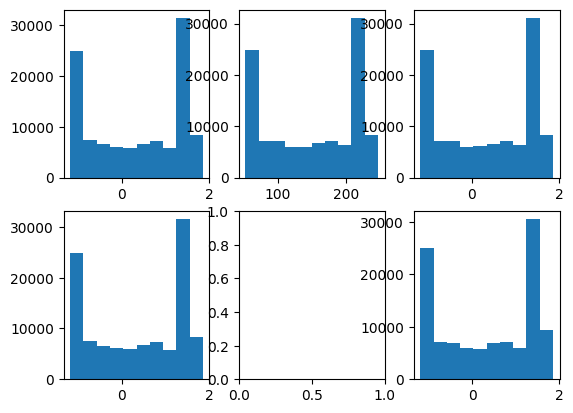

In [6]:
# quantization

X2 = (X_train/255-train_mean)/train_std

x_min, x_max = int(np.min(X2))-1, int(np.max(X2)+1)
scale = (x_max - x_min)/255

x0 = X2[0].astype(np.float32)
x1 = ((x0-x_min)/scale+0.5).astype(np.uint8)
x2 = scale*x1.astype(np.float32) + x_min

x0t = torch.from_numpy(x0).to('cuda')
x1t = torch.quantize_per_tensor(x0t, scale, x_min, torch.qint8)
x2t = torch.dequantize(x1t)

fig, axs = plt.subplots(2,3)
axs[0,0].hist(x0.flatten())
axs[0,1].hist(x1.flatten())
axs[0,2].hist(x2.flatten())
axs[1,0].hist(x0t.detach().cpu().numpy().flatten())
axs[1,2].hist(x2t.detach().cpu().numpy().flatten())
plt.show()

In [ ]:
# predictions and evaluations with quantization

DL_test = make_dataloader(X_test, Y_test, with_norm=True, mean=assumed_mean, std=assumed_std)

state_dict = torch.load('models/' + model_name + '.pt')
model_func = getattr(models, model_name)  
model = model_func().to(device_name)
model.load_state_dict(state_dict)
print('test MAPE:', evaluate(model, DL_test, torch.device(device_name), quantize=True, split_point=2))
Y, P = get_predictions(model, DL_test, device_name)
pickle.dump({'Y':Y, 'P':P}, open('V1_preds.p', 'wb'))

In [23]:
# predictions and evaluations with quantization

DL_test = make_dataloader(X_test, Y_test, with_norm=True, mean=assumed_mean, std=assumed_std)

Ys, Ps = {}, {}
for student_name in ['V1', 'V1_2_2', 'V1_2_8', 'V1_2_32']:
    model = torch.load('models/' + student_name + '.pt', map_location=device_name)
    print(student_name, 'test MAPE:', evaluate(model, DL_test, torch.device(device_name), quantize=False, split_point=2))

    Ys[student_name], Ps[student_name] = get_predictions(model, DL_test, device_name)
pickle.dump([Ys, Ps], open('V1_preds.p', 'wb'))

cuda:0
V1 test MAPE: 0.18800232
cuda:0
V1_2_2 test MAPE: 0.2825614
cuda:0
V1_2_8 test MAPE: 0.23920985
cuda:0
V1_2_32 test MAPE: 0.20971446


In [ ]:
# make trainer
trainer = Trainer(X_train, Y_train, X_val, Y_val, X_test, Y_test, train_list, val_list, test_list, train_mean, train_std)

In [ ]:
# create jobs
all_params = []

# jpg jobs
experiment_folder = 'results/jpg_quality/' + model_name + '/'
default_params = {
    'run_job':'jpg_job',
    'test_folder':'dummy_test_folder/', 
    'model_name':model_name, 
    'midpoint':128, 
    'quality':95, 
    'run_num':42,
    'device_name':device_name, 
    'random_seed':42,
    'mem_optim':True,
}
for run_num in range(10):
    for midpoint in [512, 1024]:
        for quality in [c*5 for c in range(1, 20, 2)]:
            test_name = str(midpoint) + '_' + str(quality) + '_' + str(run_num)
            test_folder =  experiment_folder + test_name + '/'
            params = default_params.copy()
            params['test_folder'] = test_folder
            params['midpoint'] = midpoint
            params['quality'] = quality
            params['run_num'] = run_num
            params['random_seed'] = run_num
            all_params.append([params[key] for key in params])

# basic jobs
experiment_folder = 'results/basic/' + model_name + '/'
default_params = {
    'run_job':'basic_job',
    'test_folder':'dummy_test_folder/', 
    'model_name':model_name, 
    'split_point':4,
    'quantize':False,
    'midpoint':128, 
    'run_num':42,
    'device_name':device_name, 
    'random_seed':42,
}
for run_num in range(10):
    for midpoint in [512, 1024]:
        for quantize in [False, True]:
            test_name = str(midpoint) + '_' + str(quantize) + '_' + str(run_num)
            test_folder =  experiment_folder + test_name + '/'
            params = default_params.copy()
            params['test_folder'] = test_folder
            params['quantize'] = quantize
            params['midpoint'] = midpoint
            params['run_num'] = run_num
            params['random_seed'] = run_num
            all_params.append([params[key] for key in params])
    
# # compression jobs
# experiment_folder = 'results/bottlefit_compression/' + model_name + '/block_2/'
# default_params = {
#     'run_job':'bottlefit_job',
#     'test_folder':'dummy_test_folder/', 
#     'model_name':model_name, 
#     'split_point':2,
#     'quantize':True,
#     'compression':64,
#     'head_block':None,
#     'tail_block':None,
#     'run_num':42,
#     'device_name':device_name, 
#     'random_seed':42,
# }
# for run_num in range(10):
#     for compression in [2**c for c in range(1, 6, 1)]:
#         for quantize in [False, True]:
#             test_name = str(compression) + '_' + str(quantize) + '_' + str(run_num)
#             test_folder =  experiment_folder + test_name + '/'
#             params = default_params.copy()
#             params['test_folder'] = test_folder
#             params['quantize'] = quantize
#             params['compression'] = compression
#             params['head_block'], params['tail_block'] = models.get_head_tail(model_name, params['split_point'], compression)
#             params['run_num'] = run_num
#             params['random_seed'] = run_num
#             all_params.append([params[key] for key in params])
        
jobs = create_jobs(all_params, instances, overwrite=False)

In [ ]:
# run jobs
print('jobs:', jobs[instance_name])
for p_idx in jobs[instance_name]:
    print('running job:', p_idx, all_params[p_idx])
    result = trainer.run_job(*all_params[p_idx])
    print('job complete!', result)

In [7]:
def read_results(results_dir, model_func=None, device=None, read_models=False, read_curves=True, read_params=False):
    test_names = [test_name for test_name in os.listdir(results_dir) if os.path.exists(results_dir + '/' + test_name +'/curves.p')]
    returns = {}
    for test_name in test_names:
        test_returns = []
        if read_models:
            model_path = os.path.join(results_dir, test_name, 'model.pt')
            model = model_func().to(device)
            model.load_state_dict(torch.load(model_path))
            test_returns.append(model)
        if read_curves:
            curves_path = os.path.join(results_dir, test_name, 'curves.p')
            curves = pickle.load(open(curves_path, 'rb'))
            test_returns.append(curves)
        if read_params:
            params_path = os.path.join(results_dir, test_name, 'params.p')
            params = pickle.load(open(params_path, 'rb'))
            test_returns.append(params)
        returns[test_name] = test_returns
    return returns

In [10]:
model_name = 'V1'

curves = read_results('results/jpg_quality/' + model_name)
test_errs_jpg = {}
for test_name in curves:
    quality = int(test_name.split('_')[0])
    run = int(test_name.split('_')[1])
    test_err = curves[test_name][0]['test_err']
    if quality not in test_errs_jpg:
        test_errs_jpg[quality] = []
    test_errs_jpg[quality].append(test_err)
plot_test_errs(test_errs_jpg, 'JPEG', jpg_bytes)

curves = read_results('results/bottlefit_compression/' + model_name + '/block_2/')
test_errs_q = {}
test_errs_nq = {}
best_runs_q = {}
best_runs_nq = {}
for test_name in curves:
    compression = int(test_name.split('_')[0])
    quantize = test_name.split('_')[1] == 'True'
    run = int(test_name.split('_')[2])
    test_err = curves[test_name][0]['test_err']
    test_errs = test_errs_nq
    best_runs = best_runs_nq
    if quantize:
        test_errs = test_errs_q
        best_runs = best_runs_q
    if compression not in best_runs:
        best_runs[compression] = [run, test_err]
    if test_err < best_runs[compression][1]:
        best_runs[compression] = [run, test_err]
    if compression not in test_errs:
        test_errs[compression] = []
    test_errs[compression].append(test_err)
plot_test_errs(test_errs_q, 'CNN_quantized', sc_bytes_quantized)
plot_test_errs(test_errs_nq, 'CNN_nonquantized', sc_bytes)

plt.xlabel('Memory[kb]')
plt.ylabel('Depth Error [MAPE]')
plt.legend()
plt.show()

print(best_runs_nq)
print(best_runs_q)

NameError: name 'plot_test_errs' is not defined

In [20]:
# calculate memory of various jpg compressions
model_name = 'V1'
jpg_bytes = {}
for quality in [1] + [c*5 for c in range(1, 20, 2)]:
    X_compressed = jpg_compress(X_test, quality, 'local/mem_sizes/jpg_quality/' + model_name + '/', test_list)
    jpg_sum = 0
    for f_idx, file in enumerate(test_list):
        file_path = 'local/mem_sizes/jpg_quality/' + model_name + '/' + test_list[f_idx].split('.')[0] + '.jpg'
        jpg_sum += os.path.getsize(file_path)
    jpg_bytes[quality] = np.round((0.001*jpg_sum/len(test_list)), 2)
print('JPEG quality : mem [kb]')
for key in jpg_bytes:
    print(key, ':', jpg_bytes[key], 'kb')

JPEG quality : mem [kb]
1 : 1.5 kb
5 : 1.87 kb
15 : 3.14 kb
25 : 4.12 kb
35 : 4.99 kb
45 : 5.75 kb
55 : 6.5 kb
65 : 7.55 kb
75 : 9.09 kb
85 : 12.02 kb
95 : 20.61 kb


In [9]:
# calculate memory of various bottlefit compressions
from models import *
model_name = 'V1'
model_func = getattr(models, model_name)  
parent = model_func().to(device_name)
split_point = 2
sc_bytes = {}
sc_bytes_quantized = {}
#for compression in [2**c for c in range(1, 6, 1)]:
    #head_block, tail_block = models.get_head_tail(model_name, split_point, compression)
    #student = create_bottleneck(parent, split_point, head_block, tail_block, device_name).to(device_name)
for compression in [2, 4, 8, 16, 32, 128]:
    head, tail = get_head_tail(model_name, split_point, compression)
    student = create_bottleneck(parent, split_point, head, tail, device_name).to(device_name)
    x = torch.from_numpy(((X_train[:1]/255-train_mean)/train_std).astype(np.float32)).to(device_name)
    for m_idx, module in enumerate(student):
        x = module(x)
        if m_idx >= split_point:
            break
    print(x.shape)
    mem = 0.001*x.element_size() * x.nelement()
    sc_bytes[compression] = np.round(mem, 2)
    x = torch.quantize_per_tensor(x, scale, x_min, torch.qint8)
    mem = 0.001*x.element_size() * x.nelement()
    sc_bytes_quantized[compression] = np.round(mem, 2)
print('SC compression : mem [kb]')
for key in sc_bytes:
    print(key, ':', sc_bytes[key], 'kb')
print('SC compression quantized : mem [kb]')
for key in sc_bytes:
    print(key, ':', sc_bytes_quantized[key], 'kb')

torch.Size([1, 2, 18, 32])
torch.Size([1, 4, 18, 32])
torch.Size([1, 8, 18, 32])
torch.Size([1, 16, 18, 32])
torch.Size([1, 32, 18, 32])
torch.Size([1, 128, 18, 32])
SC compression : mem [kb]
2 : 4.61 kb
4 : 9.22 kb
8 : 18.43 kb
16 : 36.86 kb
32 : 73.73 kb
128 : 294.91 kb
SC compression quantized : mem [kb]
2 : 1.15 kb
4 : 2.3 kb
8 : 4.61 kb
16 : 9.22 kb
32 : 18.43 kb
128 : 73.73 kb


In [ ]:
# calculate memory of various bottlefit compressions
model_name = 'ResNet152'
model_func = getattr(models, model_name)  
parent = model_func().to(device_name)
split_point = 4
sc_bytes = {}
sc_bytes_quantized = {}
#for compression in [2**c for c in range(1, 6, 1)]:
    #head_block, tail_block = models.get_head_tail(model_name, split_point, compression)
    #student = create_bottleneck(parent, split_point, head_block, tail_block, device_name).to(device_name)
for compression in [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]:
    student = model_func(compression).to(device_name)
    x = torch.from_numpy(((X_train[:1]/255-train_mean)/train_std).astype(np.float32)).to(device_name)
    for m_idx, module in enumerate(student):
        x = module(x)
        if m_idx >= split_point:
            break
    print(x.shape)
    mem = 0.001*x.element_size() * x.nelement()
    sc_bytes[compression] = np.round(mem, 2)
    x = torch.quantize_per_tensor(x, scale, x_min, torch.qint8)
    mem = 0.001*x.element_size() * x.nelement()
    sc_bytes_quantized[compression] = np.round(mem, 2)
print('SC compression : mem [kb]')
for key in sc_bytes:
    print(key, ':', sc_bytes[key], 'kb')
print('SC compression quantized : mem [kb]')
for key in sc_bytes:
    print(key, ':', sc_bytes_quantized[key], 'kb')

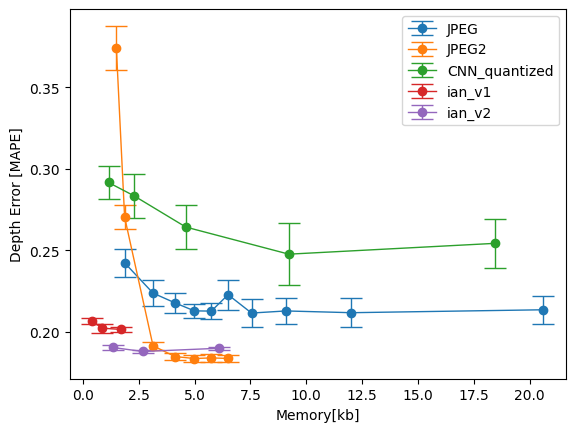

{16: [9, 0.2273803], 2: [6, 0.2858406], 32: [9, 0.20899375], 4: [8, 0.25038284], 8: [5, 0.23873988]}
{16: [2, 0.22072768], 2: [5, 0.27583468], 32: [8, 0.2169347], 4: [7, 0.26485264], 8: [2, 0.24067605]}


In [22]:
model_name = 'V1'

# plot errors of jpg vs bottlefit compression
def plot_test_errs(test_errs, label, bytes_map):
    sorted_keys = list(test_errs.keys())
    sorted_keys.sort()
    mean_errs = [np.mean(test_errs[key]) for key in sorted_keys]
    std_errs = [np.std(test_errs[key]) for key in sorted_keys]
    X = np.array([bytes_map[key] for key in sorted_keys])
    Y = np.array(mean_errs)
    Sigma = np.array(std_errs)
    plt.errorbar(X, Y, yerr=Sigma, marker='o', linewidth=1, capsize=8, capthick=1, label=label)
    return(X, Y, Sigma)

curves = read_results('results/jpg_quality/' + model_name)
test_errs_jpg = {}
for test_name in curves:
    quality = int(test_name.split('_')[0])
    run = int(test_name.split('_')[1])
    test_err = curves[test_name][0]['test_err']
    if quality not in test_errs_jpg:
        test_errs_jpg[quality] = []
    test_errs_jpg[quality].append(test_err)
X_j, Y_j, yerr_j = plot_test_errs(test_errs_jpg, 'JPEG', jpg_bytes)

test_errs_jpg2 = {1: [0.3666867780685425,
0.38613122940063477,
0.36049580574035645,
0.3629854965209961,
0.3944012808799744],
                  5: [0.26467357158660887,
0.2780094933509827,
0.2790982574224472,
0.260758935213089,
0.2693110823631287],
15: [0.1886614042520523,
0.19383054673671724,
0.18944239914417266,
0.19448589861392976,
0.1907987892627716],
25: [0.18357593297958374,
0.18667325913906097,
0.18156011283397674,
0.1880183982849121,
0.1841793417930603],
35: [0.18357593476772308,
0.18423723697662353,
0.18024450659751892,
0.18657901525497436,
0.18329229533672334],
45: [0.18330321013927459,
0.18528018653392792,
0.1799479603767395,
0.1868952125310898,
0.18438070476055146],
55: [0.18334769785404206,
0.18470013916492461,
0.17979462206363678,
0.1862060135602951,
0.18411189913749695],}
X_j2, Y_j2, yerr_j2 = plot_test_errs(test_errs_jpg2, 'JPEG2', jpg_bytes)

curves = read_results('results/bottlefit_compression/' + model_name + '/block_2/')
test_errs_q = {}
test_errs_nq = {}
best_runs_q = {}
best_runs_nq = {}
for test_name in curves:
    compression = int(test_name.split('_')[0])
    quantize = test_name.split('_')[1] == 'True'
    run = int(test_name.split('_')[2])
    test_err = curves[test_name][0]['test_err']
    test_errs = test_errs_nq
    best_runs = best_runs_nq
    if quantize:
        test_errs = test_errs_q
        best_runs = best_runs_q
    if compression not in best_runs:
        best_runs[compression] = [run, test_err]
    if test_err < best_runs[compression][1]:
        best_runs[compression] = [run, test_err]
    if compression not in test_errs:
        test_errs[compression] = []
    test_errs[compression].append(test_err)
X_q, Y_q, yerr_q = plot_test_errs(test_errs_q, 'CNN_quantized', sc_bytes_quantized)
#X_nq, Y_nq, yerr_nq = plot_test_errs(test_errs_nq, 'CNN_nonquantized', sc_bytes)

ian_bytes = {
    'v1-c12': 0.43,
    'v1-c24': 0.86, 
    'v1-c48': 1.72, 
    'v2-c12': 1.34, 
    'v2-c24': 2.69, 
    'v2-c48': 6.10,
}
ian_errs_v1 = {
    'v1-c12': [0.20508764207363128,
    0.20939167439937592,
    0.20504251956939698],
    'v1-c24': [0.2055513334274292,
    0.1989610880613327,
    0.20214587032794953],
    'v1-c48': [0.20330844402313233,
    0.2011218100786209,
    0.1998429352045059],
}
ian_errs_v2 = {
    'v2-c12': [0.19001540243625642,
    0.18895152986049651,
    0.19208188712596894],
    'v2-c24': [0.1876756715774536,
    0.18707791984081268,
    0.1889375513792038],
    'v2-c48': [0.189106624126434,
    0.19124690890312196,
    0.18930530786514282]
}
X_iv1, Y_iv1, yerr_iv1 = plot_test_errs(ian_errs_v1, 'ian_v1', ian_bytes)
X_iv2, Y_iv2, yerr_iv2 = plot_test_errs(ian_errs_v2, 'ian_v2', ian_bytes)

plt.xlabel('Memory[kb]')
plt.ylabel('Depth Error [MAPE]')
plt.legend()
plt.show()

pickle.dump([X_q, Y_q, yerr_q, X_j, Y_j, yerr_j, X_j2, Y_j2, yerr_j2, X_iv1, Y_iv1, yerr_iv1, X_iv2, Y_iv2, yerr_iv2], open('split_results2.p', 'wb'))
print(best_runs_nq)
print(best_runs_q)

In [ ]:
model_name = 'ResNet152'

# plot errors of jpg vs bottlefit compression
def plot_test_errs(test_errs, label, bytes_map):
    sorted_keys = list(test_errs.keys())
    sorted_keys.sort()
    mean_errs = [np.mean(test_errs[key]) for key in sorted_keys]
    std_errs = [np.std(test_errs[key]) for key in sorted_keys]
    X = np.array([bytes_map[key] for key in sorted_keys])
    Y = np.array(mean_errs)
    Sigma = np.array(std_errs)
    plt.errorbar(X, Y, yerr=Sigma, marker='o', linewidth=1, capsize=8, capthick=1, label=label)

curves = read_results('results/jpg_quality/' + model_name)
test_errs = {}
for test_name in curves:
    midpoint = int(test_name.split('_')[0])
    quality = int(test_name.split('_')[1])
    run = int(test_name.split('_')[2])
    test_err = curves[test_name][0]['test_err']
    if quality not in test_errs:
        test_errs[quality] = []
    test_errs[quality].append(test_err)
plot_test_errs(test_errs, 'JPEG', jpg_bytes)

curves = read_results('results/bottlefit_compression/' + model_name + '/block_2/')
test_errs_q = {}
test_errs_nq = {}
best_runs = {}
for test_name in curves:
    compression = int(test_name.split('_')[0])
    quantize = test_name.split('_')[1] == 'True'
    run = int(test_name.split('_')[2])
    test_err = curves[test_name][0]['test_err']
    test_errs = test_errs_nq
    if quantize:
        test_errs = test_errs_q
    else:
        if compression not in best_runs:
            best_runs[compression] = [run, test_err]
        if test_err < best_runs[compression][1]:
            best_runs[compression] = [run, test_err]
    if compression not in test_errs:
        test_errs[compression] = []
    test_errs[compression].append(test_err)
plot_test_errs(test_errs_q, 'CNN_quantized', sc_bytes_quantized)
plot_test_errs(test_errs_nq, 'CNN_nonquantized', sc_bytes)

plt.xlabel('Memory[kb]')
plt.ylabel('Depth Error [MAPE]')
plt.legend()
plt.show()

print(best_runs)

In [ ]:
state_dict.get_state_dict()

In [ ]:
from models import ResNet152
parent = ResNet152().to('cuda:0')
state_dict = torch.load('models/ResNet152.pt', map_location='cuda:0')
parent.load_state_dict(state_dict)